In [1]:
!git clone https://github.com/LMBTough/ABE-XAI.git

Cloning into 'ABE-XAI'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 163 (delta 7), reused 5 (delta 0), pack-reused 143 (from 2)
Receiving objects: 100% (163/163), 86.57 MiB | 11.92 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Updating files: 100% (121/121), done.


In [2]:
from torch import nn
import torch
import torch.nn.functional as F
import sys

import os
os.chdir("ABE-XAI")

class TimeSeriesPredictionModel(nn.Module):

    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=2)
        self.fc = nn.Linear(hidden_size, 36)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x



# Generate sample data for time series prediction (10 samples, each with a sequence length of 30)
sample_x = torch.rand(2, 49, 36)  # 2 samples, each being a sequence of 49 time steps, 36 features
sample_y = torch.rand(2, 49, 36)  # 2 samples, each being a sequence of 49 time steps, 36 features

target_y = torch.zeros_like(sample_y)
# Use an LSTM-based model for time series prediction

model = TimeSeriesPredictionModel(input_size=36, hidden_size=64)

sample_x, sample_y,target_y,model = sample_x.cuda(), sample_y.cuda(),target_y.cuda(),model.cuda()

In [3]:
# Let's train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for i in range(100):
    optimizer.zero_grad()
    pred_y = model(sample_x)
    loss = criterion(pred_y, sample_y)
    loss.backward()
    optimizer.step()
# Let's test the model
pred_y = model(sample_x)
print(F.mse_loss(pred_y, sample_y))  # This should be close to 0

tensor(0.0858, device='cuda:0', grad_fn=<MseLossBackward0>)


In [4]:
# before peforimg any attack, We need to define the loss function
# loss function takes only one argument, which is the batch of data
# We can define the loss function as follows
def loss_fn(batch):
    x, y = batch
    output = model(x)
    return F.mse_loss(output, y)

# Or we can define the loss function like this
def loss_fn(model,batch):
    x, y = batch
    output = model(x)
    return F.mse_loss(output, y)

from functools import partial
loss_fn = partial(loss_fn, model) # now loss_fn takes only one argument

#### Attack

In [5]:
from abe.algorithm.attack import FGSM, PGD, BIM, MIFGSM, TIFGSM, DIFGSM, SINIFGSM, SSA

In [6]:
# first we need to define the attack task
from abe.task import AttackTask
from abe.type import ModelType

task = AttackTask(loss_fn=loss_fn, model_type=ModelType.IMAGECLASSIFICATION, is_targeted=False) # for targeted attack, set is_targeted=True

# then we can define the attack algorithm

attack = BIM(task,eps=1,alpha=0.1) # BIM attack

adversarial_x = attack([sample_x, sample_y]) # all attack algorithms take a batch of data as input

targeted_task = AttackTask(loss_fn=loss_fn, model_type=ModelType.IMAGECLASSIFICATION, is_targeted=True)

targeted_attack = BIM(targeted_task,eps=1,alpha=0.1)

targeted_adversarial_x = targeted_attack([sample_x, target_y]) # for targeted attack, the second element of the batch should be the target label

In [7]:
print("Original prediction: ", model(sample_x).squeeze())
print("Adversarial prediction: ", model(adversarial_x).squeeze())
print("Targeted adversarial prediction: ", model(targeted_adversarial_x).squeeze())

Original prediction:  tensor([[[0.1660, 0.2831, 0.1246,  ..., 0.1488, 0.2045, 0.2953],
         [0.3514, 0.4101, 0.3235,  ..., 0.3347, 0.3838, 0.4335],
         [0.4395, 0.4616, 0.4348,  ..., 0.4209, 0.4682, 0.4969],
         ...,
         [0.4854, 0.4944, 0.5173,  ..., 0.4678, 0.5138, 0.5323],
         [0.4853, 0.4899, 0.5159,  ..., 0.4700, 0.5156, 0.5326],
         [0.4824, 0.4925, 0.5116,  ..., 0.4691, 0.5168, 0.5335]],

        [[0.1811, 0.2963, 0.1438,  ..., 0.1686, 0.2159, 0.3097],
         [0.3502, 0.4167, 0.3301,  ..., 0.3370, 0.3783, 0.4363],
         [0.4385, 0.4639, 0.4352,  ..., 0.4237, 0.4647, 0.4990],
         ...,
         [0.4786, 0.4958, 0.5115,  ..., 0.4628, 0.5085, 0.5296],
         [0.4802, 0.4959, 0.5104,  ..., 0.4600, 0.5091, 0.5286],
         [0.4776, 0.4965, 0.5091,  ..., 0.4596, 0.5083, 0.5303]]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
Adversarial prediction:  tensor([[[ 0.0238,  0.1742, -0.0117,  ...,  0.0103,  0.0811,  0.1954],
         [ 0.0778,

#### Explanation

In [8]:
from abe.algorithm.explanation import AMPE,IG, FastIG, SaliencyMap, SmoothGradient, MFABA

In [9]:
# first we need to define the explanation task
from abe.task import ExplanationTask

# Explanation task takes loss function and forward function as initialization arguments

def loss_fn(batch):
    x, y = batch
    output = model(x)
    return F.mse_loss(output, y)

def forward(batch):
    x, _ = batch
    return model(x)

In [10]:
explanation_task = ExplanationTask(loss_fn=loss_fn, forward_fn=forward, model_type=ModelType.TIMESERIESPREDICTION)

In [11]:
# then we can define the explanation algorithm

explanation = MFABA(explanation_task)

attribution = explanation([sample_x, sample_y])

In [12]:
attribution.shape

(2, 49, 36)

<Axes: >

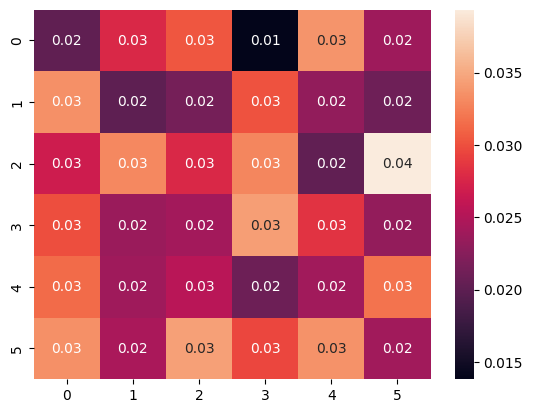

In [13]:
import seaborn as sns
min_ = attribution[0].min()
max_ = attribution[0].max()
attribution[0] = (attribution[0] - min_) / (max_ - min_)
sns.heatmap(attribution[0].mean(0).reshape(6,6),annot=True,fmt=".2f")
